# Weather predictions for: Gdansk, Szczecin, Rzeszow, Warszawa and Krakow
### Each csv file with city_2022 is ready for testing
### First execute XGB_model.ipynb and LSTM_model_for_each_30_min.ipynb notebooks

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib.ticker import MaxNLocator

from tensorflow.keras.layers import *
from sklearn.metrics import mean_absolute_error

# Preparation

In [7]:
# GLOBAL 
# relh	 skph 	temp


# mean and standard for data normalization and denormalization
mean_and_std = pd.read_csv("lstm_models/mean_and_std")
training_mean = mean_and_std['mean']
training_std = mean_and_std['std']

# lstm and xgboost biases
lstm_bias_df = pd.read_csv("lstm_models/biases_lstm")
lstm_bias_df.drop('Unnamed: 0',axis='columns', inplace=True)
xgb_bias_df = pd.read_csv("xgb_models/biases_xgboost")
xgb_bias_df.drop('Unnamed: 0',axis='columns', inplace=True)


lstm_bias = []
xgb_bias = []

for i in range(3):
    lstm_bias.append(lstm_bias_df.iloc[i].values)
    xgb_bias.append(xgb_bias_df.iloc[i].values)

In [8]:
lstm_bias

[array([ 0.83148474, -0.31474521, -0.99743677]),
 array([ 0.80291971, -0.58406145, -0.08810469]),
 array([ 1.05350063, -0.28617996, -0.09368925])]

In [9]:
lstm_bias_df

,humid,wind,temp
0,0.831485,-0.314745,-0.997437
1,0.802920,-0.584061,-0.088105
2,1.053501,-0.286180,-0.093689


In [10]:
# models load
model_lstm = []
model_lstm.append(pickle.load(open("lstm_models/lstm1.pkl", "rb", -1)))
model_lstm.append(pickle.load(open("lstm_models/lstm2.pkl", "rb", -1)))
model_lstm.append(pickle.load(open("lstm_models/lstm3.pkl", "rb", -1)))

model_xgb = []
model_xgb.append(pickle.load(open("xgb_models/xgb1.pkl", "rb", -1)))
model_xgb.append(pickle.load(open("xgb_models/xgb2.pkl", "rb", -1)))
model_xgb.append(pickle.load(open("xgb_models/xgb3.pkl", "rb", -1)))

# Global functions

In [11]:
# for LSTM
def norm(X, y, index, training_mean, training_std):
    X[:, :, index] = (X[:, :, index] - training_mean) / training_std
    y[:, index] = (y[:, index] - training_mean) / training_std


def transform_data(df_input, window_size = 12, timestamps_count = 0):
    df_input = df_input.to_numpy()
    features_len = df_input.shape[1]
    data_count = len(df_input)
    X = []
    y = []
    # Explanatory X and Response y variables 
    for i in range(data_count-window_size - timestamps_count):
        row = [r for r in df_input[i:i+window_size]]
        X.append(row)
        label = [df_input[i+window_size + timestamps_count]]
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    resh0 = y.shape[0]
    resh1 = y.shape[2]
    y = y.reshape(resh0, resh1)
    
    # data normalization
    for i in range(features_len):
        norm(X, y, i, training_mean[i], training_std[i])

    return  X, y

In [12]:
# for LSTM
def denormalization(y, training_mean, training_std):
  y = (y*training_std) + training_mean
  return y

# Calculations for Lodz

In [13]:
# Read the CSV file for Lodz
all_data = pd.read_csv("data_distance_from_Lodz/Lodz_2022.csv")
all_data.drop('Unnamed: 0',axis='columns', inplace=True)

In [14]:
# data for lstm model
all_data_lstm = all_data[["relh", "skph", "temp"]]

# data for xGBoost model
all_data_x = all_data.copy()
all_data_x.rename(columns ={'temp':'tmpc', 'skph':'sped'}, inplace=True)
all_data_x['hour'] = pd.to_datetime(all_data['time']).dt.hour
all_data_x.drop('time',axis='columns', inplace=True)
all_data_x.insert(loc=0, column="lat", value=51) # latitude for Lodz = 51
all_data_x.insert(loc=0, column="lon", value=19) # longtitude for Lodz = 19

all_data_x = all_data_x[all_data_x['minutes'] == 0]
all_data_x.drop('minutes',axis='columns', inplace=True)

In [15]:
MAE_humid_lstm = []
MAE_wind_lstm = []
MAE_temp_lstm = []

for hour in range(3): # cause predicitons for next 3 hours
    X, y = transform_data(all_data_lstm,12,hour)
    # # make predictions
    predictions = model_lstm[hour].predict(X)

    pred = []
    actual =[]
    
    features_len = y.shape[1]
    for i in range(features_len):
        denormalized = denormalization(predictions[:,i], training_mean[i], training_std[i]) - lstm_bias[hour][i]
        pred.append(denormalized)
        actual.append(denormalization(y[:,i], training_mean[i], training_std[i]))
    MAE_humid_lstm.append(mean_absolute_error(actual[0], pred[0]))
    MAE_wind_lstm.append(mean_absolute_error(actual[1], pred[1]))
    MAE_temp_lstm.append(mean_absolute_error(actual[2], pred[2]))


546/546 [==============================] - 2s 3ms/step


In [16]:
MAE_humid_xgb = []
MAE_wind_xgb = []
MAE_temp_xgb = []

for hour in range(1,4): # cause predicitons for next 3 hours
    # # make predictions
    X = all_data_x[:-hour]
    y = all_data_x[hour:]
    y_pred_xgb = model_xgb[hour-1].predict(X)
    y_pred_xgb = pd.DataFrame(y_pred_xgb, columns=[ "lon", "lat",  "tmpc",  "relh" ,"sped" ,"day","month", "year", "hour"])

    MAE_humid_xgb.append(mean_absolute_error(y_pred_xgb[["relh"]] - xgb_bias[hour-1][0],y[["relh"]]))
    MAE_wind_xgb.append(mean_absolute_error(y_pred_xgb[["sped"]]- xgb_bias[hour-1][1],y[["sped"]]))
    MAE_temp_xgb.append(mean_absolute_error(y_pred_xgb[["tmpc"]]- xgb_bias[hour-1][2],y[["tmpc"]]))

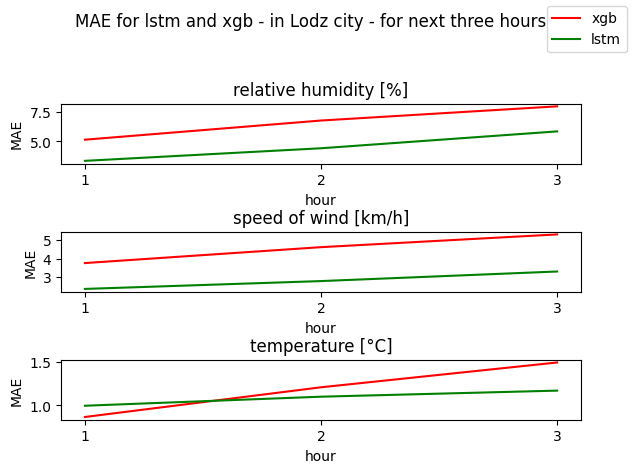

In [51]:
fig, axs = plt.subplots(3)
fig.suptitle('MAE for lstm and xgb - in Lodz city - for next three hours')
fig.tight_layout(pad=2.8)
xaxis = [1,2,3]
axs[0].plot(xaxis,MAE_humid_xgb, 'r', label ='xgb')
axs[0].plot(xaxis,MAE_humid_lstm,'g', label ='lstm')
axs[0].set_title('relative humidity [%]')
axs[0].set_xlabel('hour')
axs[0].set_ylabel('MAE')

axs[1].plot(xaxis,MAE_wind_xgb,'r')
axs[1].plot(xaxis,MAE_wind_lstm,'g')
axs[1].set_title('speed of wind [km/h]')
axs[1].set_xlabel('hour')
axs[1].set_ylabel('MAE')

axs[2].plot(xaxis,MAE_temp_xgb,'r')
axs[2].plot(xaxis,MAE_temp_lstm,'g')
axs[2].set_title('temperature [°C]')
axs[2].set_xlabel('hour')
axs[2].set_ylabel('MAE')
fig.legend()
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[2].xaxis.set_major_locator(MaxNLocator(integer=True))

In [18]:
res = {}
long_lat = {
    "Gdansk_2022_lon":18.64,"Gdansk_2022_lat":54.35, "Krakow_2022_lon":19.9450,"Krakow_2022_lat":50.0647, "Rzeszow_2022_lon": 22, "Rzeszow_2022_lat":50.04  ,
      "Szczecin_2022_lon":14.55, "Szczecin_2022_lat":53.42, "Warszawa_2022_lon":21.01, "Warszawa_2022_lat":52.22
}

MAE_lstm_all = {}
MAE_xgb_all = {}

all_cities = ["Gdansk_2022", "Krakow_2022", "Rzeszow_2022", "Szczecin_2022", "Warszawa_2022"]

for city in all_cities:
    print(city)
    fileName = "data_distance_from_Lodz/" + city + ".csv"
    all_data = pd.read_csv(fileName)
    all_data.drop('Unnamed: 0',axis='columns', inplace=True)

    # data for lstm model #####################
    all_data_lstm = all_data[["relh", "skph", "temp"]]

    # data for xGBoost model #####################
    all_data_x = all_data.copy()
    all_data_x.rename(columns ={'temp':'tmpc', 'skph':'sped'}, inplace=True)
    all_data_x['hour'] = pd.to_datetime(all_data['time']).dt.hour
    all_data_x.drop('time',axis='columns', inplace=True)

    # different lon and lat
    lon = long_lat[city+"_lon"]
    lat = long_lat[city+"_lat"]
    all_data_x.insert(loc=0, column="lat", value=lat) 
    all_data_x.insert(loc=0, column="lon", value=lon) 

    all_data_x = all_data_x[all_data_x['minutes'] == 0]
    all_data_x.drop('minutes',axis='columns', inplace=True)

    ######################### LSTM ###############################

    MAE_humid_lstm_temp = []
    MAE_wind_lstm_temp = []
    MAE_temp_lstm_temp = []

    for hour in range(3): # cause predicitons for next 3 hours
        X, y = transform_data(all_data_lstm,12,hour)
        # # make predictions
        predictions = model_lstm[hour].predict(X)

        pred = []
        actual =[]
        
        features_len = y.shape[1]
        for i in range(features_len):
            denormalized = denormalization(predictions[:,i], training_mean[i], training_std[i]) - lstm_bias[hour][i]
            pred.append(denormalized)
            actual.append(denormalization(y[:,i], training_mean[i], training_std[i]))

        MAE_humid_lstm_temp.append(mean_absolute_error(actual[0], pred[0]))
        MAE_wind_lstm_temp.append(mean_absolute_error(actual[1], pred[1]))
        MAE_temp_lstm_temp.append(mean_absolute_error(actual[2], pred[2]))
    # save data for each place
    MAE_lstm_all[city] = [MAE_humid_lstm_temp, MAE_wind_lstm_temp, MAE_temp_lstm_temp]

    ########################### XGB #############################
    MAE_humid_xgb_temp = []
    MAE_wind_xgb_temp = []
    MAE_temp_xgb_temp = []

    for hour in range(1,4): # cause predicitons for next 3 hours
        # # make predictions
        X = all_data_x[:-hour]
        y = all_data_x[hour:]
        y_pred_xgb = model_xgb[hour-1].predict(X)
        y_pred_xgb = pd.DataFrame(y_pred_xgb, columns=[ "lon", "lat",  "tmpc",  "relh" ,"sped" ,"day","month", "year", "hour"])

        MAE_humid_xgb_temp.append(mean_absolute_error(y_pred_xgb[["relh"]] - xgb_bias[hour-1][0],y[["relh"]]))
        MAE_wind_xgb_temp.append(mean_absolute_error(y_pred_xgb[["sped"]]- xgb_bias[hour-1][1],y[["sped"]]))
        MAE_temp_xgb_temp.append(mean_absolute_error(y_pred_xgb[["tmpc"]]- xgb_bias[hour-1][2],y[["tmpc"]]))

    # save data for each place
    MAE_xgb_all[city] = [MAE_humid_xgb_temp, MAE_wind_xgb_temp, MAE_temp_xgb_temp]     


Gdansk_2022
1055/1055 [==============================] - 3s 3ms/step
Krakow_2022
1055/1055 [==============================] - 3s 3ms/step
Rzeszow_2022
1055/1055 [==============================] - 3s 3ms/step
Szczecin_2022
1055/1055 [==============================] - 3s 3ms/step
Warszawa_2022
1055/1055 [==============================] - 3s 3ms/step


In [19]:
all_cities = ["Gdansk_2022", "Krakow_2022", "Rzeszow_2022", "Szczecin_2022", "Warszawa_2022"]

# Results!

### lstm and xgboost predictions comparison in dataframes for each weather condition: humidity, speed of wind and temperature
#### row number 0: predictions for next hour
#### row number 1: predictions for second hour
#### row number 2: predictions for third hour

In [45]:
# humidity

data_h = pd.DataFrame()
data_h['Lodz_2022_lstm'] = MAE_humid_lstm
data_h['Lodz_2022_xgb'] = MAE_humid_xgb

for city in all_cities:
    name_lstm = city + "_lstm"
    data_h[name_lstm] = MAE_lstm_all[city][0]

    name_xgb = city + "_xgb"
    data_h[name_xgb] = MAE_xgb_all[city][0]

data_h

,Lodz_2022_lstm,Lodz_2022_xgb,Gdansk_2022_lstm,Gdansk_2022_xgb,Krakow_2022_lstm,Krakow_2022_xgb,Rzeszow_2022_lstm,Rzeszow_2022_xgb,Szczecin_2022_lstm,Szczecin_2022_xgb,Warszawa_2022_lstm,Warszawa_2022_xgb
0,3.339148,5.146359,3.323791,4.953667,3.444758,5.074596,3.242920,4.871978,3.362156,4.973015,3.315619,4.931727
1,4.414556,6.784207,4.336985,6.486423,4.462875,6.622744,4.250173,6.386112,4.413671,6.583742,4.361974,6.477689
2,5.855911,7.996344,5.601535,7.654113,5.751173,7.627145,5.494080,7.449992,5.823375,7.569436,5.813924,7.507710


In [48]:
# speed of wind (km/h)

data_w = pd.DataFrame()
data_w['Lodz_2022_lstm'] = MAE_wind_lstm
data_w['Lodz_2022_xgb'] = MAE_wind_xgb

for city in all_cities:
    name_lstm = city + "_lstm"
    data_w[name_lstm] = MAE_lstm_all[city][1]

    name_xgb = city + "_xgb"
    data_w[name_xgb] = MAE_xgb_all[city][1]

data_w

,Lodz_2022_lstm,Lodz_2022_xgb,Gdansk_2022_lstm,Gdansk_2022_xgb,Krakow_2022_lstm,Krakow_2022_xgb,Rzeszow_2022_lstm,Rzeszow_2022_xgb,Szczecin_2022_lstm,Szczecin_2022_xgb,Warszawa_2022_lstm,Warszawa_2022_xgb
0,2.375271,3.758981,2.522493,3.740568,2.432547,3.849901,2.578992,3.843621,2.274960,3.496746,2.271222,3.495888
1,2.794998,4.610370,3.018200,4.591725,2.918774,4.750187,3.049490,4.624865,2.738184,4.243924,2.711934,4.237604
2,3.308089,5.292672,3.565342,5.104830,3.422574,5.363036,3.493999,5.068658,3.164445,4.700902,3.124038,4.706232


In [47]:
# temperature
data_t = pd.DataFrame()
data_t['Lodz_2022_lstm'] = MAE_temp_lstm
data_t['Lodz_2022_xgb'] = MAE_temp_xgb

for city in all_cities:
    name_lstm = city + "_lstm"
    data_t[name_lstm] = MAE_lstm_all[city][2]

    name_xgb = city + "_xgb"
    data_t[name_xgb] = MAE_xgb_all[city][2]

data_t

,Lodz_2022_lstm,Lodz_2022_xgb,Gdansk_2022_lstm,Gdansk_2022_xgb,Krakow_2022_lstm,Krakow_2022_xgb,Rzeszow_2022_lstm,Rzeszow_2022_xgb,Szczecin_2022_lstm,Szczecin_2022_xgb,Warszawa_2022_lstm,Warszawa_2022_xgb
0,0.996181,0.865854,0.881587,0.793081,0.981013,0.875503,0.973752,0.810965,0.936543,0.817798,1.026078,0.818999
1,1.100889,1.209801,1.015421,1.121991,1.066585,1.233011,1.065296,1.157473,1.043563,1.145257,1.122935,1.141224
2,1.171196,1.496836,1.035853,1.403700,1.143191,1.513577,1.069632,1.436414,1.134995,1.387101,1.135959,1.404091


### lstm predictions for next three hours for different cities
#### row number 0: predictions for next hour
#### row number 1: predictions for second hour
#### row number 2: predictions for third hour

In [46]:
# humidity lstm only

data_h_lstm = pd.DataFrame()
data_h_lstm['Lodz_2022_lstm'] = MAE_humid_lstm

for city in all_cities:
    name_lstm = city + "_lstm"
    data_h_lstm[name_lstm] = MAE_lstm_all[city][0]

data_h_lstm

,Lodz_2022_lstm,Gdansk_2022_lstm,Krakow_2022_lstm,Rzeszow_2022_lstm,Szczecin_2022_lstm,Warszawa_2022_lstm
0,3.339148,3.323791,3.444758,3.242920,3.362156,3.315619
1,4.414556,4.336985,4.462875,4.250173,4.413671,4.361974
2,5.855911,5.601535,5.751173,5.494080,5.823375,5.813924


In [23]:
# speed of wind lstm only (km/h)

data_w_lstm = pd.DataFrame()
data_w_lstm['Lodz_2022_lstm'] = MAE_wind_lstm

for city in all_cities:
    name_lstm = city + "_lstm"
    data_w_lstm[name_lstm] = MAE_lstm_all[city][1]

data_w_lstm

,Lodz_2022_lstm,Gdansk_2022_lstm,Krakow_2022_lstm,Rzeszow_2022_lstm,Szczecin_2022_lstm,Warszawa_2022_lstm
0,2.375271,2.522493,2.432547,2.578992,2.274960,2.271222
1,2.794998,3.018200,2.918774,3.049490,2.738184,2.711934
2,3.308089,3.565342,3.422574,3.493999,3.164445,3.124038


In [25]:
# temperature lstm only
data_t_lstm = pd.DataFrame()
data_t_lstm['Lodz_2022_lstm'] = MAE_temp_lstm

for city in all_cities:
    name_lstm = city + "_lstm"
    data_t_lstm[name_lstm] = MAE_lstm_all[city][2]

data_t_lstm

,Lodz_2022_lstm,Gdansk_2022_lstm,Krakow_2022_lstm,Rzeszow_2022_lstm,Szczecin_2022_lstm,Warszawa_2022_lstm
0,0.996181,0.881587,0.981013,0.973752,0.936543,1.026078
1,1.100889,1.015421,1.066585,1.065296,1.043563,1.122935
2,1.171196,1.035853,1.143191,1.069632,1.134995,1.135959


### Conclusion:
Even the LSTM model has been learned on only historic data from Łódź city - there is no huge impact on predictions from different cities.